In [125]:
import numpy as np
from scipy.stats import norm, lognorm
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
os.chdir('/Users/fulinq/Documents/SET_Intern/SOMC/TradingData')

In [126]:
def lognormal(s, s0, r, sigma, t):
    mu = -(np.log(s) - np.log(s0) - (r - 0.5 * sigma**2) * t) ** 2 / (2 * sigma**2 * t)
    sigma_t = 1 / (s * sigma * np.sqrt(2 * np.pi * t))
    
    
    return sigma_t * np.exp(mu)

In [127]:
def d(sigma, s, k,r,t):
    d1 = (np.log(s / k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return d1, d2

In [128]:
df_price = pd.read_csv(r"SET 50 Historical Data (9).csv")
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price = df_price.sort_values(by='Date').reset_index(drop=True)
df_price.set_index('Date', inplace=True)
df_price['Price'] = df_price['Price'].str.replace(',', '', regex=False)
df_price['Price'] = pd.to_numeric(df_price['Price'], errors='coerce')

In [129]:
file_path = r"SOMC Data SET Clear.xlsx"

# อ่านเฉพาะ Vol
df_vol = pd.read_excel(file_path, sheet_name="SET50 Volatility")

# อ่านเฉพาะ Zero Yield
df_rf = pd.read_excel(file_path, sheet_name="Zero Yield (Rf)")

# ตรวจสอบข้อมูล
print(df_vol.head())
print(df_rf.head())

   CALC_DATE SETL_DM_CODE   PROD_CODE  HIS_VLT
0   20200102         SD01  SET50_OPT   10.8110
1   20200103         SD01  SET50_OPT   10.4420
2   20200106         SD01  SET50_OPT   11.7821
3   20200107         SD01  SET50_OPT   12.1831
4   20200108         SD01  SET50_OPT   13.6843
   BIZ_DATE SOURCE_TYPE                            TIME       TTM     YIELD
0  20200102           A  2020-01-02T00:00:00</asof       0.076712  1.148501
1  20200102           A  2020-01-02T00:00:00</asof       0.249315  1.157958
2  20200102           A  2020-01-02T00:00:00</asof       0.498630  1.177817
3  20200102           A  2020-01-02T00:00:00</asof       1.000000  1.197676
4  20200102           A  2020-01-02T00:00:00</asof       2.000000  1.139669


In [130]:
df_vol['CALC_DATE'] = pd.to_datetime(df_vol['CALC_DATE'], format='%Y%m%d')
df_vol.set_index('CALC_DATE', inplace=True)

df_rf['BIZ_DATE'] = pd.to_datetime(df_rf['BIZ_DATE'], format='%Y%m%d')
df_rf.set_index('BIZ_DATE', inplace=True)

print(df_vol.head())
print(df_rf.head())

           SETL_DM_CODE   PROD_CODE  HIS_VLT
CALC_DATE                                   
2020-01-02         SD01  SET50_OPT   10.8110
2020-01-03         SD01  SET50_OPT   10.4420
2020-01-06         SD01  SET50_OPT   11.7821
2020-01-07         SD01  SET50_OPT   12.1831
2020-01-08         SD01  SET50_OPT   13.6843
           SOURCE_TYPE                            TIME       TTM     YIELD
BIZ_DATE                                                                  
2020-01-02           A  2020-01-02T00:00:00</asof       0.076712  1.148501
2020-01-02           A  2020-01-02T00:00:00</asof       0.249315  1.157958
2020-01-02           A  2020-01-02T00:00:00</asof       0.498630  1.177817
2020-01-02           A  2020-01-02T00:00:00</asof       1.000000  1.197676
2020-01-02           A  2020-01-02T00:00:00</asof       2.000000  1.139669


In [131]:
df_rf_fix = df_rf[df_rf['TTM'] == 1.0][['YIELD']]
print(df_vol)

           SETL_DM_CODE   PROD_CODE  HIS_VLT
CALC_DATE                                   
2020-01-02         SD01  SET50_OPT   10.8110
2020-01-03         SD01  SET50_OPT   10.4420
2020-01-06         SD01  SET50_OPT   11.7821
2020-01-07         SD01  SET50_OPT   12.1831
2020-01-08         SD01  SET50_OPT   13.6843
...                 ...         ...      ...
2025-03-25         SD01  SET50_OPT   19.9875
2025-03-26         SD01  SET50_OPT   19.6598
2025-03-27         SD01  SET50_OPT   19.2603
2025-03-28         SD01  SET50_OPT   19.1930
2025-03-31         SD01  SET50_OPT   19.3716

[1274 rows x 3 columns]


In [132]:
valid_dates = df_vol.dropna().index.intersection(df_rf_fix.dropna().index)

# เช็กว่ามีวันที่ที่ซ้อนกันจริงไหม
if len(valid_dates) > 0:
    last_valid_date = valid_dates.max()

    # หา S0 จาก df_price
    if last_valid_date in df_price.index:
        S0 = float(df_price.loc[last_valid_date, 'Price'])
    else:
        # หาใกล้สุดก่อนหน้า (forward-fill)
        S0 = float(df_price['Price'].ffill().loc[:last_valid_date].iloc[-1])

    # ใช้ค่า volatility และ rf จากวันสุดท้ายที่มีข้อมูลพร้อมกัน
    sigma = float(df_vol.loc[last_valid_date, 'HIS_VLT'])/100
    r = float(df_rf_fix.loc[last_valid_date, 'YIELD'])/100

    print(f"📅 ใช้ข้อมูลวันที่: {last_valid_date}")
    print(f"🎯 S0 = {S0}, σ = {sigma}, r = {r}")

else:
    raise ValueError("❌ ไม่พบวันที่ที่ df_vol และ df_rf_fix มีข้อมูลพร้อมกันเลย")


📅 ใช้ข้อมูลวันที่: 2025-03-31 00:00:00
🎯 S0 = 739.77, σ = 0.193716, r = 0.01820906


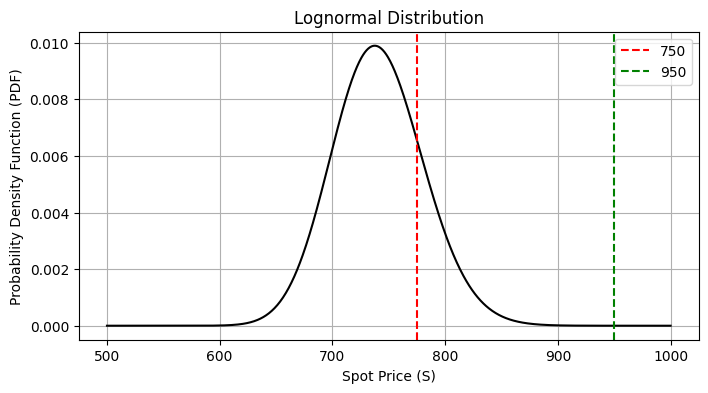

In [137]:
# s0 = 906.23
# r = 0.01988605
t = 20/252
# sigma = 0.193716

s = np.linspace(500, 1000, 1000)

plt.figure(figsize=(8, 4))
plt.plot(s, lognormal(s , S0, r, sigma, t), 'k')
plt.axvline(x=775, color='red', linestyle='--', label='750')
plt.axvline(x=950, color='green', linestyle='--', label='950')
plt.title('Lognormal Distribution')
plt.xlabel('Spot Price (S)')
plt.ylabel('Probability Density Function (PDF)')
plt.legend()
plt.grid()

In [ ]:
l_series = 550
u_series = 950
otm_series = list()
for i in range(l_series, u_series + 1, 25):
    nd1 = round(norm.cdf(d(sigma, S0, i, r, t)[0]), 4)
    print(f'{i} : {nd1}')
    if nd1 > 0.5:
        continue
    else:
        otm_series.append(i)
print()
print(f"🔍 OTM Strike Prices: {otm_series}")

550 : 1.0
575 : 1.0
600 : 1.0
625 : 0.9992
650 : 0.9923
675 : 0.9584
700 : 0.8569
725 : 0.664
750 : 0.4216
775 : 0.2122
800 : 0.0837
825 : 0.0259
850 : 0.0064
875 : 0.0013
900 : 0.0002
925 : 0.0
950 : 0.0

🔍 OTM Strike Prices: [750, 775, 800, 825, 850, 875, 900, 925, 950]


0.40033885752197773

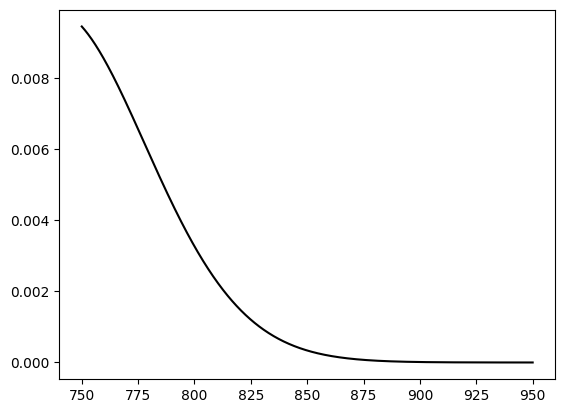

In [146]:
s = np.linspace(min(otm_series), max(otm_series), 1000)
plt.plot(s, lognormal(s , S0, r, sigma, t), 'k')
np.trapz(lognormal(s ,S0, r, sigma, t), s)

In [150]:
d120 = d(sigma, 739.77, 950, r, t)[1]
d100 = d(sigma, 739.77, 750, r, t)[1]

abs(norm.cdf(d100) - norm.cdf(d120))

0.4003386210326076